代码参考：
https://discourse.qingxzd.com/t/pytorch/58

辅助参考:
https://www.pythonf.cn/read/128035

In [1]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

from torchtext.legacy import data,datasets

import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torchtext.vocab import Vectors
from torch.nn import init

from sklearn.model_selection import train_test_split
import jieba    # 用来预处理文本（分词等）


import nltk
from nltk.corpus import stopwords
from tqdm import tqdm


In [2]:
seed=2019
torch.manual_seed(seed)
torch.backends.cudnn.deterministic=True

DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")   # 选择Gpu或Cpu

In [3]:
df=pd.read_csv('data/train.tsv', sep='\t')
df_test=pd.read_csv('data/test.tsv', sep='\t')

In [4]:
train, val = train_test_split(df, test_size=0.2)
train.to_csv("./data/train.csv", index=False)
val.to_csv("./data/val.csv", index=False)

In [21]:
def tokenizer(text):    
    return [wd for wd in jieba.cut(text, cut_all=False)]

en_stopwords=stopwords.words('english')

FIX_LENGTH=50
LABEL = data.Field(sequential=False, use_vocab=False)

TEXT = data.Field(sequential=True, tokenize=tokenizer,fix_length=FIX_LENGTH, lower=True, stop_words=en_stopwords)

In [22]:
train, val = data.TabularDataset.splits(
    path='./data', train='train.csv', validation='val.csv', format='csv', skip_header=True,
    fields=[('PhraseId', None), ('SentenceId', None), ('Phrase', TEXT), ('Sentiment', LABEL)]
)

test = data.TabularDataset('./data/test.tsv', format='tsv', skip_header=True, 
                           fields=[('PhraseId', None), ('SentenceId', None), ('Phrase', TEXT)])
print(len(train),train[2].Phrase, train[2].Sentiment)

124848 [' ', ' ', ' ', 'new', ' ', 'yorker', ' ', '--', ' ', ' ', ',', ' ', 'really', ' ', ',', ' ', ' ', ' ', ' ', 'human', ' ', ' ', '--', ' ', ' ', ' ', 'weeks', ' ', ' ', '9', '\\', '/', '11'] 2


In [23]:
# # 建立vocab（不需要加载预训练的词向量） 
# TEXT.build_vocab(train, val)
# LABEL.build_vocab(train, val)

# 建立vocab（加载预训练的词向量，如果路径没有该词向量，会自动下载）
# TEXT.build_vocab(train, vectors='glove.6B.100d')#, max_size=30000)
TEXT.build_vocab(train)#, max_size=30000)

# 当 corpus 中有的 token 在 vectors 中不存在时 的初始化方式.
# TEXT.vocab.vectors.unk_init = init.xavier_uniform

In [24]:
# 构造迭代器
'''
sort_key指在一个batch内根据文本长度进行排序。
'''
train_iter = data.BucketIterator(train, batch_size=128, sort_key=lambda x: len(x.Phrase), 
                                 shuffle=True,device=DEVICE)

val_iter = data.BucketIterator(val, batch_size=128, sort_key=lambda x: len(x.Phrase), 
                                 shuffle=True,device=DEVICE)

# 在 test_iter , sort一定要设置成 False, 要不然会被 torchtext 搞乱样本顺序
test_iter = data.Iterator(dataset=test, batch_size=128, train=False,
                          sort=False, device=DEVICE)

# 查看trainiter一个batch

# batch = next(iter(train_iter))
# a= batch.Phrase
# label = batch.Sentiment
# print(a.shape)
# print(batch.Phrase)

In [25]:
#文本中的唯一标记
print("Size of TEXT vocabulary:",len(TEXT.vocab))

#标签中唯一令牌的集合
# print("Size of LABEL vocabulary:",len(LABEL.vocab))

#常用单词
# print(TEXT.vocab.freqs.most_common(10))

# 词库向量的大小
# print(TEXT.vocab.vectors.shape)
#单词词典
# print(LABEL.vocab.stoi)

Size of TEXT vocabulary: 15156


In [40]:
embedding_size = 60
sequence_length = FIX_LENGTH # every sentences contains sequence_length(=3) words
num_classes = 5  # 0 or 1
batch_size = 128

vocab_size = len(TEXT.vocab)

class TextCNN(nn.Module):
    def __init__(self):
        super(TextCNN, self).__init__()
        self.W = nn.Embedding(vocab_size, embedding_size)
        output_channel = 3
        self.conv = nn.Sequential(
            # conv : [input_channel(=1), output_channel, (filter_height, filter_width), stride=1]
            nn.Conv2d(1, output_channel, (2, embedding_size)),
            nn.ReLU(),
            # pool : ((filter_height, filter_width))
            nn.MaxPool2d((FIX_LENGTH-1, 1)),
        )
        # fc
        self.fc = nn.Linear(output_channel, num_classes)

    def forward(self, X):
      '''
      X: [batch_size, sequence_length]
      '''
      batch_size = X.shape[0]
    #   print(batch_size)
      embedding_X = self.W(X) # [batch_size, sequence_length, embedding_size]
    #   print(embedding_X.shape)
      embedding_X = embedding_X.unsqueeze(1) # add channel(=1) [batch, channel(=1), sequence_length, embedding_size]
    #   print(embedding_X.shape)
      conved = self.conv(embedding_X) # [batch_size, output_channel, 1, 1]
    #   print(conved.shape)
      flatten = conved.view(batch_size, -1) # [batch_size, output_channel*1*1]
    #   print(flatten.shape)
      output = self.fc(flatten)
      return output



model = TextCNN()

#定义优化器和损失
optimizer = optim.Adam(model.parameters())
criterion = nn.CrossEntropyLoss()
#定义度量指标
def binary_accuracy(preds, y):

    #round预测到最接近的整数
    # rounded_preds = torch.round(preds)
    correct = (preds == y).float() 
    acc = correct.sum() / len(correct)
    return acc
#转化为cuda（如果可用）
model = model.to(DEVICE)
criterion = criterion.to(DEVICE)
print(model)
#可训练参数的数量
def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)
print(f'The model has {count_parameters(model):,} trainable parameters')

TextCNN(
  (W): Embedding(15156, 60)
  (conv): Sequential(
    (0): Conv2d(1, 3, kernel_size=(2, 60), stride=(1, 1))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=(49, 1), stride=(49, 1), padding=0, dilation=1, ceil_mode=False)
  )
  (fc): Linear(in_features=3, out_features=5, bias=True)
)
The model has 909,743 trainable parameters


In [36]:
# batch=next(iter(train_iter))
# print(batch.Phrase.shape)
# text = batch.Phrase
# text = text.permute(1,0)
# A=torch.ones([128,1,50,60])

# cov=nn.Conv2d(1, 3, (2, embedding_size))
# act=nn.ReLU()
#             # pool : ((filter_height, filter_width))
# pool=nn.MaxPool2d((49, 1))


# out=cov(A)
# print(out.shape)
# out=act(out)
# print(out.shape)
# out=pool(out)
# print(out.shape)

torch.Size([50, 128])
torch.Size([128, 3, 49, 1])
torch.Size([128, 3, 49, 1])
torch.Size([128, 3, 1, 1])


In [41]:
batch=next(iter(train_iter))
print(batch.Phrase.shape)
text = batch.Phrase
text = text.permute(1,0)
predictions = model(text).squeeze()
print(predictions.shape)
print(batch.Sentiment.shape)

loss = criterion(predictions, batch.Sentiment)
        #计算二分类准确度
print(loss)
predictions_val=  predictions.argmax(dim=1)

print(predictions_val)
acc = binary_accuracy(predictions_val, batch.Sentiment.float())
print(acc)
        #后向传播损失并计算梯度
loss.backward()

torch.Size([50, 128])
torch.Size([128, 5])
torch.Size([128])
tensor(1.5005, device='cuda:0', grad_fn=<NllLossBackward>)
tensor([2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
        2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
        2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
        2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
        2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
        2, 2, 2, 2, 2, 2, 2, 2], device='cuda:0')
tensor(0.5000, device='cuda:0')


In [42]:
def Train(model, iterator, optimizer, criterion):
    #每个epoch进行初始化
    epoch_loss = 0
    epoch_acc = 0
    #将模型设置为训练阶段
    model.train()
    predictions_val=[]
    for batch in tqdm(iterator):
        #重设梯度
        optimizer.zero_grad()
        #获取文本和单词数量
        text = batch.Phrase
        text = text.permute(1,0)
        # print(text.shape)
        #转换为一维张量
        predictions = model(text).squeeze()
        #计算loss
        loss = criterion(predictions, batch.Sentiment)
        #计算二分类准确度
        predictions_val=  predictions.argmax(dim=1)


        acc = binary_accuracy(predictions_val, batch.Sentiment.float())
        #后向传播损失并计算梯度
        loss.backward()
        #更新权重
        optimizer.step()
        #损失和准确度
        
        epoch_loss += loss.item()  
        epoch_acc += acc.item()
    
    return epoch_loss / len(iterator), epoch_acc / len(iterator)

def Evaluate(model, iterator, criterion):
    #每个epoch进行初始化
    epoch_loss = 0
    epoch_acc = 0
    #停用dropout层
    model.eval()
    #停用自动求导
    with torch.no_grad():
        for batch in tqdm(iterator):
            #获取文本和单词数量
            text = batch.Phrase
            text = text.permute(1,0)
            #转换为一维张量
            predictions = model(text).squeeze()
            #计算损失和准确度
            loss = criterion(predictions, batch.Sentiment)
            predictions_val=   predictions.argmax(dim=1)

            acc = binary_accuracy(predictions_val, batch.Sentiment.float())
            #跟踪损失和准确度
            epoch_loss += loss.item()
            epoch_acc += acc.item()
    return epoch_loss / len(iterator), epoch_acc / len(iterator)

def Test(model, iterator, criterion):
    #每个epoch进行初始化
    epoch_loss = 0
    epoch_acc = 0
    #停用dropout层
    model.eval()
    predict_list=[]
    #停用自动求导
    with torch.no_grad():
        for batch in tqdm(iterator):
            #获取文本和单词数量
            text = batch.Phrase
            text = text.permute(1,0)
            #转换为一维张量
            predictions = model(text).squeeze()
            #计算损失和准确度

            predict=   predictions.argmax(dim=1).cpu()
            predict_list+=predict.numpy().flatten().tolist()

    return predict_list

In [43]:
N_EPOCHS = 50
best_valid_loss = float('inf')

train_loss_list=[]
valid_loss_list=[]
train_acc_list=[]
valid_acc_list=[]

for epoch in range(N_EPOCHS):
    #训练模型
    print('epoch:',epoch)
    train_loss, train_acc = Train(model, train_iter, optimizer, criterion)
    #评估模型
    valid_loss, valid_acc = Evaluate(model, val_iter, criterion)
    #保存模型
    if valid_loss < best_valid_loss:
        best_valid_loss = valid_loss
        torch.save(model.state_dict(), 'saved_weights.pt')

    train_loss_list.append(train_loss)
    valid_loss_list.append(valid_loss)
    train_acc_list.append(train_acc)
    valid_acc_list.append(valid_acc)

    print(f'\tTrain Loss: {train_loss:.3f} | Train Acc: {train_acc*100:.2f}%')
    print(f'\t Val. Loss: {valid_loss:.3f} |  Val. Acc: {valid_acc*100:.2f}%')

epoch: 0


100%|██████████| 244/244 [00:00<00:00, 529.16it/s]


	Train Loss: 1.258 | Train Acc: 51.37%
	 Val. Loss: 1.210 |  Val. Acc: 52.70%
epoch: 1


100%|██████████| 244/244 [00:00<00:00, 527.16it/s]


	Train Loss: 1.179 | Train Acc: 53.73%
	 Val. Loss: 1.158 |  Val. Acc: 54.34%
epoch: 2


100%|██████████| 244/244 [00:00<00:00, 502.18it/s]


	Train Loss: 1.127 | Train Acc: 55.45%
	 Val. Loss: 1.129 |  Val. Acc: 55.56%
epoch: 3


100%|██████████| 244/244 [00:00<00:00, 532.46it/s]


	Train Loss: 1.100 | Train Acc: 56.33%
	 Val. Loss: 1.115 |  Val. Acc: 56.00%
epoch: 4


100%|██████████| 244/244 [00:00<00:00, 491.25it/s]


	Train Loss: 1.083 | Train Acc: 56.74%
	 Val. Loss: 1.110 |  Val. Acc: 56.29%
epoch: 5


100%|██████████| 244/244 [00:00<00:00, 463.67it/s]


	Train Loss: 1.072 | Train Acc: 57.22%
	 Val. Loss: 1.105 |  Val. Acc: 56.39%
epoch: 6


100%|██████████| 244/244 [00:00<00:00, 487.83it/s]


	Train Loss: 1.064 | Train Acc: 57.44%
	 Val. Loss: 1.099 |  Val. Acc: 56.53%
epoch: 7


100%|██████████| 244/244 [00:00<00:00, 512.11it/s]


	Train Loss: 1.055 | Train Acc: 57.72%
	 Val. Loss: 1.098 |  Val. Acc: 56.22%
epoch: 8


100%|██████████| 244/244 [00:00<00:00, 522.83it/s]


	Train Loss: 1.046 | Train Acc: 58.02%
	 Val. Loss: 1.090 |  Val. Acc: 56.76%
epoch: 9


100%|██████████| 244/244 [00:00<00:00, 515.11it/s]


	Train Loss: 1.036 | Train Acc: 58.39%
	 Val. Loss: 1.082 |  Val. Acc: 57.21%
epoch: 10


100%|██████████| 244/244 [00:00<00:00, 479.54it/s]


	Train Loss: 1.026 | Train Acc: 58.86%
	 Val. Loss: 1.079 |  Val. Acc: 57.68%
epoch: 11


100%|██████████| 244/244 [00:00<00:00, 529.19it/s]


	Train Loss: 1.019 | Train Acc: 59.30%
	 Val. Loss: 1.075 |  Val. Acc: 57.24%
epoch: 12


100%|██████████| 244/244 [00:00<00:00, 542.49it/s]


	Train Loss: 1.013 | Train Acc: 59.50%
	 Val. Loss: 1.073 |  Val. Acc: 57.41%
epoch: 13


100%|██████████| 244/244 [00:00<00:00, 525.05it/s]


	Train Loss: 1.008 | Train Acc: 59.75%
	 Val. Loss: 1.064 |  Val. Acc: 57.80%
epoch: 14


100%|██████████| 244/244 [00:00<00:00, 519.35it/s]


	Train Loss: 1.003 | Train Acc: 59.94%
	 Val. Loss: 1.060 |  Val. Acc: 58.07%
epoch: 15


100%|██████████| 244/244 [00:00<00:00, 531.54it/s]


	Train Loss: 0.997 | Train Acc: 60.13%
	 Val. Loss: 1.054 |  Val. Acc: 58.32%
epoch: 16


100%|██████████| 244/244 [00:00<00:00, 516.63it/s]


	Train Loss: 0.985 | Train Acc: 60.51%
	 Val. Loss: 1.046 |  Val. Acc: 58.41%
epoch: 17


100%|██████████| 244/244 [00:00<00:00, 525.59it/s]


	Train Loss: 0.974 | Train Acc: 60.97%
	 Val. Loss: 1.036 |  Val. Acc: 59.01%
epoch: 18


100%|██████████| 244/244 [00:00<00:00, 521.91it/s]


	Train Loss: 0.966 | Train Acc: 61.19%
	 Val. Loss: 1.033 |  Val. Acc: 59.23%
epoch: 19


100%|██████████| 244/244 [00:00<00:00, 512.67it/s]


	Train Loss: 0.960 | Train Acc: 61.39%
	 Val. Loss: 1.031 |  Val. Acc: 59.27%
epoch: 20


100%|██████████| 244/244 [00:00<00:00, 522.57it/s]


	Train Loss: 0.956 | Train Acc: 61.65%
	 Val. Loss: 1.029 |  Val. Acc: 59.42%
epoch: 21


100%|██████████| 244/244 [00:00<00:00, 515.21it/s]


	Train Loss: 0.951 | Train Acc: 61.74%
	 Val. Loss: 1.026 |  Val. Acc: 59.62%
epoch: 22


100%|██████████| 244/244 [00:00<00:00, 509.53it/s]


	Train Loss: 0.948 | Train Acc: 61.96%
	 Val. Loss: 1.026 |  Val. Acc: 59.39%
epoch: 23


100%|██████████| 244/244 [00:00<00:00, 530.44it/s]


	Train Loss: 0.945 | Train Acc: 62.06%
	 Val. Loss: 1.025 |  Val. Acc: 59.56%
epoch: 24


100%|██████████| 244/244 [00:00<00:00, 478.07it/s]


	Train Loss: 0.942 | Train Acc: 62.06%
	 Val. Loss: 1.022 |  Val. Acc: 59.75%
epoch: 25


100%|██████████| 244/244 [00:00<00:00, 518.73it/s]


	Train Loss: 0.940 | Train Acc: 62.25%
	 Val. Loss: 1.022 |  Val. Acc: 59.84%
epoch: 26


100%|██████████| 244/244 [00:00<00:00, 525.21it/s]


	Train Loss: 0.939 | Train Acc: 62.30%
	 Val. Loss: 1.024 |  Val. Acc: 59.88%
epoch: 27


100%|██████████| 244/244 [00:00<00:00, 518.56it/s]


	Train Loss: 0.937 | Train Acc: 62.41%
	 Val. Loss: 1.023 |  Val. Acc: 59.72%
epoch: 28


100%|██████████| 244/244 [00:00<00:00, 394.67it/s]


	Train Loss: 0.936 | Train Acc: 62.38%
	 Val. Loss: 1.023 |  Val. Acc: 59.77%
epoch: 29


100%|██████████| 244/244 [00:00<00:00, 525.43it/s]


	Train Loss: 0.934 | Train Acc: 62.44%
	 Val. Loss: 1.028 |  Val. Acc: 59.37%
epoch: 30


100%|██████████| 244/244 [00:00<00:00, 513.38it/s]


	Train Loss: 0.933 | Train Acc: 62.47%
	 Val. Loss: 1.025 |  Val. Acc: 59.73%
epoch: 31


100%|██████████| 244/244 [00:00<00:00, 530.75it/s]


	Train Loss: 0.932 | Train Acc: 62.51%
	 Val. Loss: 1.021 |  Val. Acc: 59.84%
epoch: 32


100%|██████████| 244/244 [00:00<00:00, 519.87it/s]


	Train Loss: 0.930 | Train Acc: 62.56%
	 Val. Loss: 1.025 |  Val. Acc: 59.68%
epoch: 33


100%|██████████| 244/244 [00:00<00:00, 490.68it/s]


	Train Loss: 0.929 | Train Acc: 62.58%
	 Val. Loss: 1.023 |  Val. Acc: 59.61%
epoch: 34


100%|██████████| 244/244 [00:00<00:00, 507.51it/s]


	Train Loss: 0.928 | Train Acc: 62.66%
	 Val. Loss: 1.019 |  Val. Acc: 60.13%
epoch: 35


100%|██████████| 244/244 [00:00<00:00, 435.05it/s]


	Train Loss: 0.927 | Train Acc: 62.67%
	 Val. Loss: 1.020 |  Val. Acc: 59.87%
epoch: 36


100%|██████████| 244/244 [00:00<00:00, 528.96it/s]


	Train Loss: 0.926 | Train Acc: 62.76%
	 Val. Loss: 1.027 |  Val. Acc: 59.74%
epoch: 37


100%|██████████| 244/244 [00:00<00:00, 524.45it/s]


	Train Loss: 0.925 | Train Acc: 62.74%
	 Val. Loss: 1.022 |  Val. Acc: 60.06%
epoch: 38


100%|██████████| 244/244 [00:00<00:00, 548.73it/s]


	Train Loss: 0.924 | Train Acc: 62.84%
	 Val. Loss: 1.021 |  Val. Acc: 59.91%
epoch: 39


100%|██████████| 244/244 [00:00<00:00, 555.92it/s]


	Train Loss: 0.923 | Train Acc: 62.79%
	 Val. Loss: 1.023 |  Val. Acc: 59.87%
epoch: 40


100%|██████████| 244/244 [00:00<00:00, 561.12it/s]


	Train Loss: 0.922 | Train Acc: 62.90%
	 Val. Loss: 1.026 |  Val. Acc: 59.70%
epoch: 41


100%|██████████| 244/244 [00:00<00:00, 428.21it/s]


	Train Loss: 0.922 | Train Acc: 62.85%
	 Val. Loss: 1.022 |  Val. Acc: 59.82%
epoch: 42


100%|██████████| 244/244 [00:00<00:00, 528.66it/s]


	Train Loss: 0.921 | Train Acc: 62.95%
	 Val. Loss: 1.021 |  Val. Acc: 60.08%
epoch: 43


100%|██████████| 244/244 [00:00<00:00, 516.73it/s]


	Train Loss: 0.921 | Train Acc: 62.91%
	 Val. Loss: 1.022 |  Val. Acc: 59.92%
epoch: 44


100%|██████████| 244/244 [00:00<00:00, 528.99it/s]


	Train Loss: 0.920 | Train Acc: 62.88%
	 Val. Loss: 1.028 |  Val. Acc: 59.44%
epoch: 45


100%|██████████| 244/244 [00:00<00:00, 531.82it/s]


	Train Loss: 0.920 | Train Acc: 62.94%
	 Val. Loss: 1.023 |  Val. Acc: 59.96%
epoch: 46


100%|██████████| 244/244 [00:00<00:00, 431.64it/s]


	Train Loss: 0.919 | Train Acc: 62.96%
	 Val. Loss: 1.024 |  Val. Acc: 59.73%
epoch: 47


100%|██████████| 244/244 [00:00<00:00, 514.47it/s]


	Train Loss: 0.918 | Train Acc: 62.98%
	 Val. Loss: 1.022 |  Val. Acc: 59.93%
epoch: 48


100%|██████████| 244/244 [00:00<00:00, 534.02it/s]


	Train Loss: 0.918 | Train Acc: 62.99%
	 Val. Loss: 1.024 |  Val. Acc: 60.05%
epoch: 49


100%|██████████| 244/244 [00:00<00:00, 519.74it/s]

	Train Loss: 0.917 | Train Acc: 63.04%
	 Val. Loss: 1.019 |  Val. Acc: 60.17%


![](./pic/textCNN-random-loss-50.jpg)


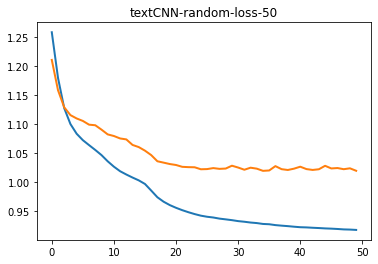

![](./pic/textCNN-random-acc-50.jpg)


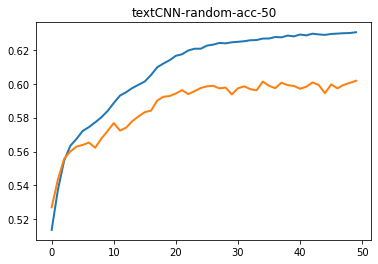

In [44]:


def drawpic(train_loss_list=[],test_loss_list=[],epoch_number=10,title='1',root_path='./'):
    # make data
    x = [i for i in range(epoch_number)]
    # plot
    fig, ax = plt.subplots()
    plt.title(title)
    ax.plot(x, train_loss_list, linewidth=2.0)
    ax.plot(x, test_loss_list, linewidth=2.0)
    path=root_path+title+'.jpg'
    print('![]({})'.format(path))
    plt.savefig(path)
    plt.show()
root_path='./pic/'
title='textCNN-random-loss-{}'.format(str(N_EPOCHS))

drawpic(train_loss_list=train_loss_list,test_loss_list=valid_loss_list,epoch_number=N_EPOCHS,title=title,root_path=root_path)

title='textCNN-random-acc-{}'.format(str(N_EPOCHS))

drawpic(train_loss_list=train_acc_list,test_loss_list=valid_acc_list,epoch_number=N_EPOCHS,title=title,root_path=root_path)

In [ ]:
predict=Test(model, test_iter, criterion)
len(predict)


100%|██████████| 518/518 [00:01<00:00, 280.20it/s]


66292

In [ ]:

df_test=pd.read_csv('./data/sampleSubmission.csv')
df_test['Sentiment']=predict
df_test.to_csv('./submission.csv',index=None)

In [ ]:
#加载权重
path='./saved_weights.pt'
model.load_state_dict(torch.load(path))
model.eval()
#推断 

def predict(model, text):
    tokenized = [wd for wd in jieba.cut(text, cut_all=False)]
  #令牌化(tokenize)句子 
    indexed = [TEXT.vocab.stoi[t] for t in tokenized]          #转换为整数序列
    length = [len(indexed)]                                    #计算单词个数
    tensor = torch.LongTensor(indexed).to(DEVICE)              #转换为张量
    tensor = tensor.unsqueeze(1).T                             #reshape成[batch, 单词个数]
    length_tensor = torch.LongTensor(length)                   #转换为张量
    prediction = model(tensor)                  #预测
    return prediction.item()

#进行预测
print(predict(model, "fuck fuck shit bitch?"))
#不真诚的问题
print(predict(model, "Why Indian girls go crazy about marrying Shri. Rahul Gandhi ji?"))

ValueError: only one element tensors can be converted to Python scalars